In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, Lambda, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Define a custom R2 score metric for TensorFlow
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [3]:
def train_and_evaluate_gru_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features: time steps, predicted GL, and predicted NN values
    features = ['Timesteps [- / 5 minutes]', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    if flag_train:
        # Define the input shapes
        time_steps = X_train_scaled.shape[1]

        # Inputs for q_physics and q_nn
        input_q_physics = Input(shape=(time_steps, 1), name='input_q_physics')
        input_q_nn = Input(shape=(time_steps, 1), name='input_q_nn')

        # Concatenate the features for GRU processing
        input_features = Concatenate()([input_q_physics, input_q_nn])

        # GRU layer to process the time series data
        gru_output = GRU(units=64, return_sequences=False)(input_features)
        gru_output = Flatten()(gru_output)  # Flatten the output

        # Dense layer to predict weights (w_physics and w_nn)
        weights = Dense(2, activation='softmax', name='weights')(gru_output)
        w_physics = Lambda(lambda x: x[:, 0])(weights)
        w_nn = Lambda(lambda x: x[:, 1])(weights)

        # Flatten the inputs for y_hat calculation
        q_physics_flatten = Flatten()(input_q_physics)
        q_nn_flatten = Flatten()(input_q_nn)

        # Define y_hat calculation function
        def compute_y_hat(args):
            q_physics, w_physics, q_nn, w_nn = args
            # Make sure to reshape the weights to be applied correctly
            w_physics = tf.reshape(w_physics, (-1, 1))
            w_nn = tf.reshape(w_nn, (-1, 1))
            return tf.reduce_sum(q_physics * w_physics + q_nn * w_nn, axis=-1, keepdims=True)

        y_hat = Lambda(compute_y_hat)([q_physics_flatten, w_physics, q_nn_flatten, w_nn])

        # Define the model
        model = Model(inputs=[input_q_physics, input_q_nn], outputs=y_hat)

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Train the model
        history = model.fit([X_train_scaled, X_train_scaled], y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save the model and scaler
        model.save(f'gru-models/{target_variable}_gru_model.keras')
        joblib.dump(scaler, f'gru-models/{target_variable}_gru_scaler.pkl')

        # Predict using the trained model
        y_hat_test = model.predict([X_test_scaled, X_test_scaled])
    else:
        # Load the model and scaler
        loaded_model = load_model(f'gru-models/{target_variable}_gru_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        scaler = joblib.load(f'gru-models/{target_variable}_gru_scaler.pkl')

        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Predict using the loaded model
        y_hat_test = loaded_model.predict([X_test_scaled, X_test_scaled])

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 526.8492 - mae: 22.9073 - r2_score_metric: -1797.5806 - val_loss: 516.4396 - val_mae: 22.6853 - val_r2_score_metric: -1419.8411
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 524.0908 - mae: 22.8419 - r2_score_metric: -1223.0485 - val_loss: 516.4396 - val_mae: 22.6853 - val_r2_score_metric: -1419.8411
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 525.0453 - mae: 22.8664 - r2_score_metric: -1364.1268 - val_loss: 516.4396 - val_mae: 22.6853 - val_r2_score_metric: -1419.8411
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 523.6201 - mae: 22.8332 - r2_score_metric: -1403.1434 - val_loss: 516.4396 - val_mae: 22.6853 - val_r2_score_metric: -1419.8411
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 524.6797 - mae: 22.8589 - r2_score_metric: -1302.7651 - val_loss: 516.4396 - val_mae: 22.6853 - val_r2_score_metric: -1419.8411
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

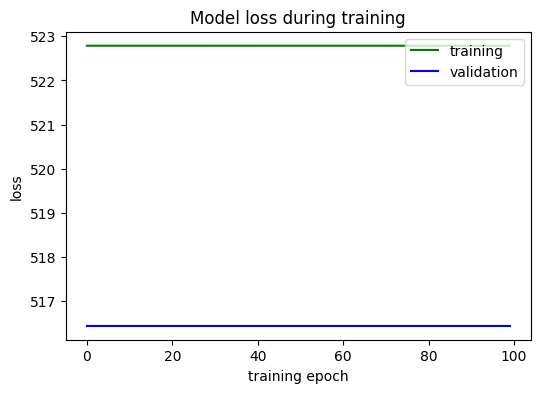

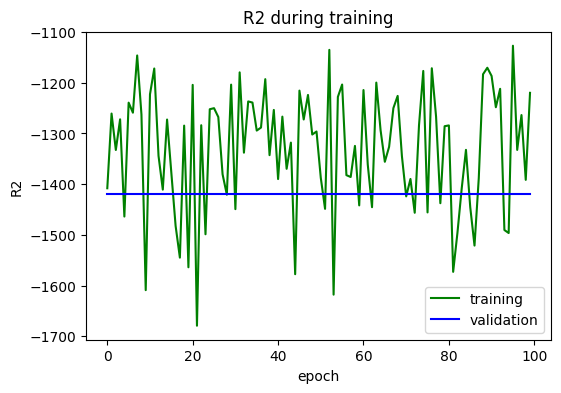

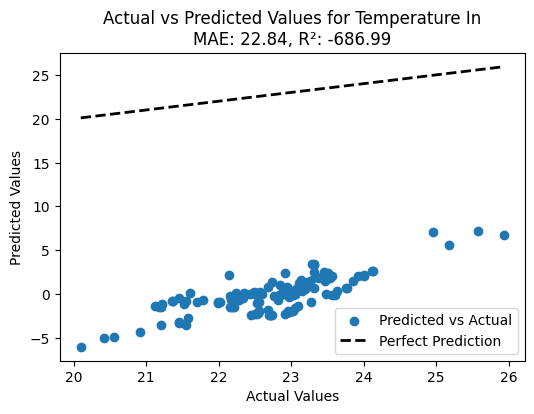

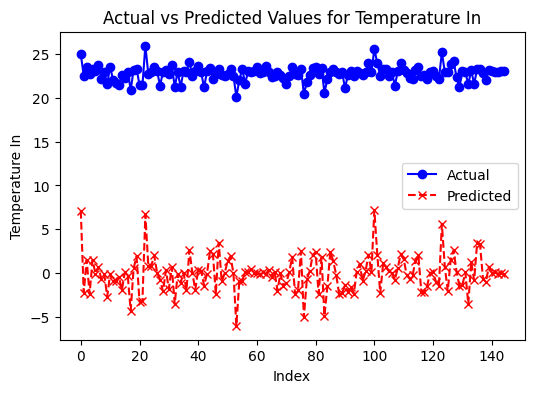

In [4]:
train_and_evaluate_gru_model('Temperature In', flag_train=True, _epochs=100, _batch_size=10)

In [7]:
train_and_evaluate_gru_model('Temperature In', flag_train=False)

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().